# Comparaison entre les 2 signaux sur une même fenêtre d'observation

## Importation des librairies nécéssaires

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from datetime import datetime

# Preparation des données

## Importation

In [5]:
data_real = pd.read_csv('./data1.csv', sep=";")
data_real_2 = pd.read_csv('./data2.csv', sep=";")

## Affichage

In [7]:
#  Série 1
data = data_real.iloc[:, [0, 1, 6]].to_numpy()
time_serie = pd.Series(data[:, 2], dtype='float64')
time_serie = time_serie.dropna()

#  Série 2
data2 = data_real_2.iloc[:, [0, 1, 6]].to_numpy()
time_serie2 = pd.Series(data2[:, 2], dtype='float64')
time_serie2 = time_serie2.dropna()

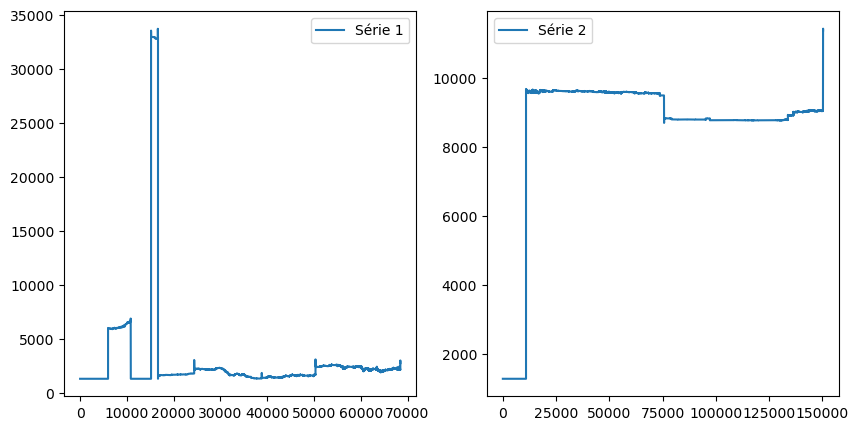

In [9]:
# Affichage des séries
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(time_serie, label='Série 1')
ax[0].legend()
ax[1].plot(time_serie2, label='Série 2')
ax[1].legend()
plt.show()

# Nettoyage des données

Dans le 2e signal, on a avait pu observer que certaines données étaient dupliquées. On va donc commencer par les supprimer.

In [12]:
# Suppression données dupliquées série 2
df_crop = pd.DataFrame(data2)
df_crop = df_crop.drop_duplicates(subset=1, keep='first')

Dates des relevés de la série 1 :  2021.08.05 16:20  -  2021.08.31 23:55
Nombre de données séries 1 :  7580
Dates des relevés de la série 2 :  2021.08.05 16:20  -  2021.08.31 23:55
Nombre de données séries 2 :  7580


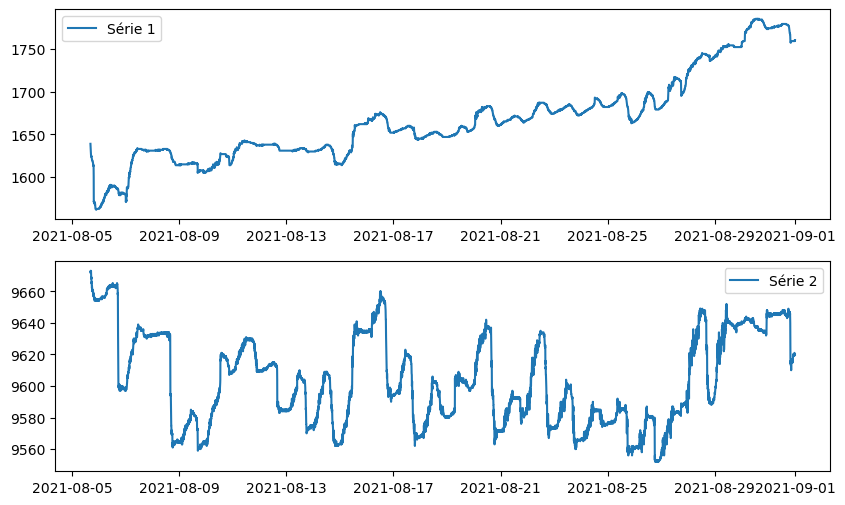

In [22]:
# Fenêtre d'observation série 1
data_crop = data[16656:24236,:] 
time_serie_crop = pd.Series(data_crop[:,2], dtype='float64')

# Fenêtre d'observation série 2
data_crop2 = df_crop.iloc[10884:18464, :].to_numpy()
time_serie_crop2 = pd.Series(data_crop2[:,2], dtype='float64')

# Création de l'axe des abscisses (dates)
data_time = data_crop[:, 1] 
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]

# Vérification des fenêtres d'observations
print("Dates des relevés de la série 1 : ", data_crop[0,1], " - ", data_crop[-1,1])
print("Nombre de données séries 1 : ", len(data_crop[:,1]))
print("Dates des relevés de la série 2 : ", data_crop2[0,1], " - ", data_crop2[-1,1])
print("Nombre de données séries 2 : ", len(data_crop2[:,1]))

# Affichage des séries
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(datetime_data,time_serie_crop, label='Série 1')
ax[0].legend()
ax[1].plot(datetime_data,time_serie_crop2, label='Série 2')
ax[1].legend()
plt.show()

In [24]:
# Pas de temps de la série 1
data_time = data_real.iloc[16656:24236, 1].to_numpy()
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]
differences_minutes = [
    (datetime_data[i] - datetime_data[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data))
]

print("Différences en minutes entre chaque données pour la série 1:")
print(np.unique(differences_minutes))

# Pas de temps de la série 2
data_time2 = df_crop.iloc[10884:18464, 1].to_numpy()
datetime_data2 = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time2]
differences_minutes2 = [
    (datetime_data2[i] - datetime_data2[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data2))
]

print("Différences en minutes entre chaque données pour data 2:")
print(np.unique(differences_minutes2))


Différences en minutes entre chaque données pour la série 1:
[5.]
Différences en minutes entre chaque données pour data 2:
[5.]


# Autocorrélation des signaux

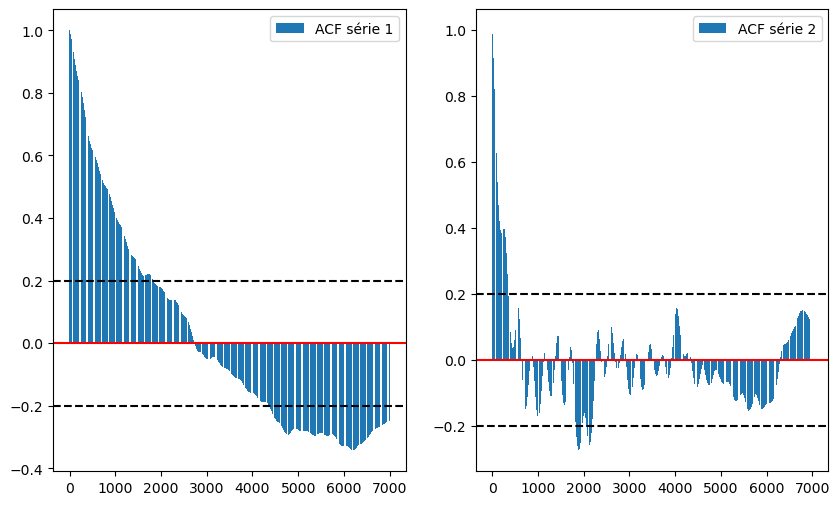

In [28]:
max_lag = 7000
acf_values_1 = sm.tsa.acf(time_serie_crop, nlags = max_lag)
acf_values_2 = sm.tsa.acf(time_serie_crop2, nlags = max_lag)

# Affichage de l'autocorrélation
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].bar(range(max_lag + 1), acf_values_1, label='ACF série 1')
ax[0].axhline(y=0.2, color='black', linestyle='--')
ax[0].axhline(y=0, color='red')
ax[0].axhline(y=-0.2, color='black', linestyle='--')
ax[0].legend()
ax[1].bar(range(max_lag + 1), acf_values_2, label='ACF série 2')
ax[1].axhline(y=0.2, color='black', linestyle='--')
ax[1].axhline(y=0, color='red')
ax[1].axhline(y=-0.2, color='black', linestyle='--')
ax[1].legend()
plt.show()

## Transformée de Fourier

rfft calcule la FFT pour un signal réel, ce qui est plus efficace et donne un résultat simplifié. La FFT transforme le signal data_ajust (une série temporelle) en une série de composantes fréquentielles, exprimées sous forme de nombres complexes.
np.real : Prend la partie réelle de la FFT, ce qui correspond aux amplitudes des composantes fréquentielles, en éliminant la partie imaginaire.

Dans le graphe, on prend la première moitié des fréquences et des amplitudes, car la seconde moitié (au-delà de la fréquence de Nyquist) est symétrique et n'apporte pas d'information nouvelle pour un signal réel.

In [27]:
def freq_to_day (freq) :
    return (1/freq)/(60*24*24)

Période ayant la plus grande amplitude 2.2689176245210727 j


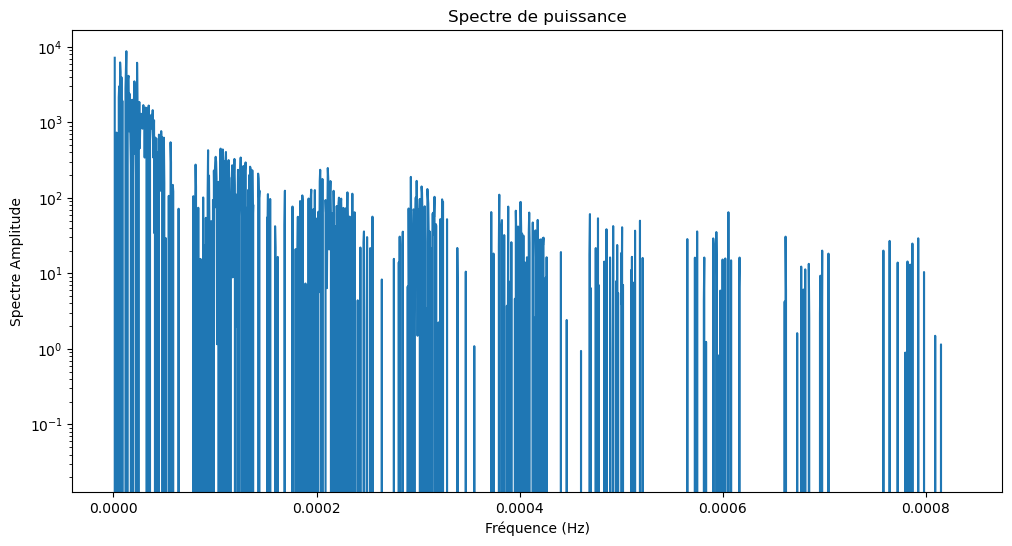

In [29]:
amplitudes = np.real(np.fft.rfft(data_ajust))[3:] # Les 2 premières sont bizarres
frequencies = np.fft.rfftfreq(len(data_ajust),5*60)[3:] # 900 = 5*60 : un point tout les 5 min

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies[:len(frequencies)//2], amplitudes[:len(amplitudes)//2], label='Spectre original')
# Affichage du spectre avec les amplitudes moyennes par bloc
plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
print("Période ayant la plus grande amplitude", freq_to_day(frequencies[np.argmax(amplitudes)]),"j" )

On observe sur ce signal que :
- La fréquence correspondante au cycle diurne n'est pas captée
- Nous n'avons pas une fréquence et des harmoniques mais des agglomérats autour des fréquences de références

Nous allons donc moyenner les fréquences pour obtenir qu'une seule fréquence par agglomérat

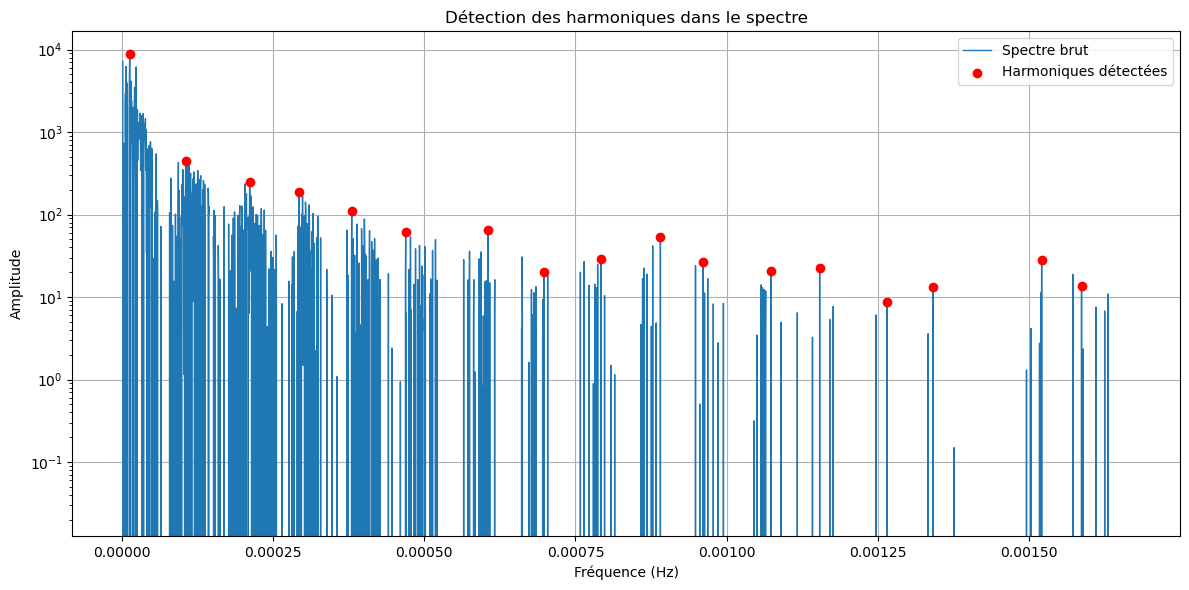

Harmoniques détectées :
Fréquence : 0.000013 Hz, Fréquence : 2.268918 jours, Amplitude : 8768.55
Fréquence : 0.000106 Hz, Fréquence : 0.274161 jours, Amplitude : 449.65
Fréquence : 0.000211 Hz, Fréquence : 0.137080 jours, Amplitude : 248.88
Fréquence : 0.000293 Hz, Fréquence : 0.098797 jours, Amplitude : 189.86
Fréquence : 0.000380 Hz, Fréquence : 0.076156 jours, Amplitude : 110.29
Fréquence : 0.000469 Hz, Fréquence : 0.061667 jours, Amplitude : 61.08
Fréquence : 0.000539 Hz, Fréquence : 0.053713 jours, Amplitude : -43.72
Fréquence : 0.000606 Hz, Fréquence : 0.047784 jours, Amplitude : 64.66
Fréquence : 0.000698 Hz, Fréquence : 0.041461 jours, Amplitude : 20.05
Fréquence : 0.000792 Hz, Fréquence : 0.036514 jours, Amplitude : 29.20
Fréquence : 0.000891 Hz, Fréquence : 0.032493 jours, Amplitude : 53.23
Fréquence : 0.000961 Hz, Fréquence : 0.030100 jours, Amplitude : 26.95
Fréquence : 0.001073 Hz, Fréquence : 0.026956 jours, Amplitude : 20.76
Fréquence : 0.001154 Hz, Fréquence : 0.025076 

In [91]:
from scipy.signal import find_peaks

# Détection des pics
prominence = 1  
distance = 150  
peaks, properties = find_peaks(amplitudes, prominence=prominence, distance=distance)

# Extraction des harmoniques
harmonic_frequencies = frequencies[peaks]
harmonic_amplitudes = amplitudes[peaks]

# Tracé du spectre et des harmoniques
plt.figure(figsize=(12, 6))

plt.plot(frequencies, amplitudes, label='Spectre brut', linewidth=1)
plt.scatter(harmonic_frequencies, harmonic_amplitudes, color='red', label='Harmoniques détectées', zorder=5)

plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.title('Détection des harmoniques dans le spectre')
plt.xscale('linear')
plt.yscale('log')  # Échelle logarithmique pour clarifier les pics
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print("Harmoniques détectées :")
for f, a in zip(harmonic_frequencies, harmonic_amplitudes):
    print(f"Fréquence : {f:.6f} Hz, Fréquence : {freq_to_day(f):.6f} jours, Amplitude : {a:.2f}")


In [31]:
def average_by_chunk(frequencies, amplitudes, chunk_size=50):
    # Calcul du nombre de blocs
    num_chunks = len(frequencies) // chunk_size
    avg_frequencies = []
    avg_amplitudes = []
    
    # Diviser en blocs et calculer la moyenne
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        # Sélectionner les indices du bloc
        chunk_frequencies = frequencies[start_idx:end_idx]
        chunk_amplitudes = amplitudes[start_idx:end_idx]
        
        # Calculer la fréquence moyenne (c'est la fréquence du centre du bloc)
        avg_frequency = np.mean(chunk_frequencies)
        
        # Calculer l'amplitude moyenne du bloc
        avg_amplitude = np.mean(chunk_amplitudes)
        
        avg_frequencies.append(avg_frequency)
        avg_amplitudes.append(avg_amplitude)
    
    return np.array(avg_frequencies), np.array(avg_amplitudes)


Harmoniques détectées avec bloc=90:
Fréquence : 0.000021 Hz, Fréquence : 1.385234 jours, Amplitude : 261.63
Fréquence : 0.000060 Hz, Fréquence : 0.478535 jours, Amplitude : -183.30
Fréquence : 0.000100 Hz, Fréquence : 0.289225 jours, Amplitude : 45.68
Fréquence : 0.000140 Hz, Fréquence : 0.207240 jours, Amplitude : -5.98
Fréquence : 0.000179 Hz, Fréquence : 0.161469 jours, Amplitude : -89.10
Fréquence : 0.000219 Hz, Fréquence : 0.132259 jours, Amplitude : 23.62
Fréquence : 0.000258 Hz, Fréquence : 0.111998 jours, Amplitude : -94.64
Fréquence : 0.000298 Hz, Fréquence : 0.097120 jours, Amplitude : 5.36
Fréquence : 0.000338 Hz, Fréquence : 0.085731 jours, Amplitude : -71.41
Fréquence : 0.000377 Hz, Fréquence : 0.076733 jours, Amplitude : -54.14
Fréquence : 0.000417 Hz, Fréquence : 0.069444 jours, Amplitude : -36.95
Fréquence : 0.000456 Hz, Fréquence : 0.063420 jours, Amplitude : -84.96
Fréquence : 0.000496 Hz, Fréquence : 0.058358 jours, Amplitude : -31.30
Fréquence : 0.000535 Hz, Fréquen

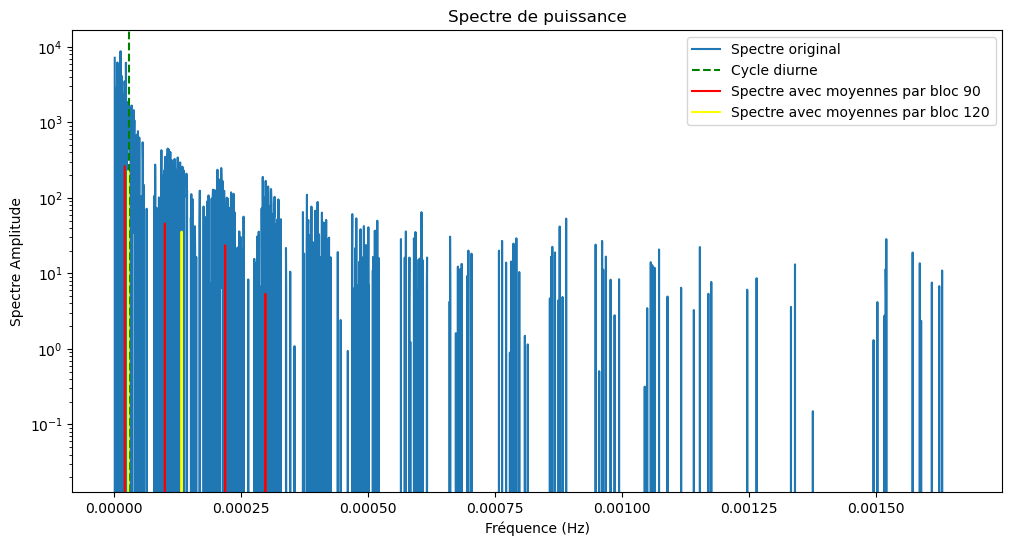

In [99]:


plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, amplitudes, label='Spectre original')
plt.axvline(x=1/(60*24*24), color='green', linestyle='--',label='Cycle diurne')

chunk_size = 90
frequencies_avg_90, amplitudes_avg_90 = average_by_chunk(frequencies, amplitudes, chunk_size)
plt.semilogy(frequencies_avg_90, amplitudes_avg_90,  label='Spectre avec moyennes par bloc 90', color='red')
#print("Période ayant la plus grande amplitude", freq_to_day(frequencies_avg[np.argmax(amplitudes_avg)]),"j avec chunk =", chunk_size )

chunk_size = 120
frequencies_avg_120, amplitudes_avg_120 = average_by_chunk(frequencies, amplitudes, chunk_size)
plt.semilogy(frequencies_avg_120, amplitudes_avg_120,  label='Spectre avec moyennes par bloc 120', color='yellow')
#print("Période ayant la plus grande amplitude", freq_to_day(frequencies_avg[np.argmax(amplitudes_avg)]),"j avec chunk =", chunk_size )

# Affichage du spectre avec les amplitudes moyennes par bloc
plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
plt.legend()

print("Harmoniques détectées avec bloc=90:")
for f, a in zip(frequencies_avg_90, amplitudes_avg_90):
    print(f"Fréquence : {f:.6f} Hz, Fréquence : {freq_to_day(f):.6f} jours, Amplitude : {a:.2f}")

print("Harmoniques détectées avec bloc 120:")
for f, a in zip(frequencies_avg_120, amplitudes_avg_120):
    print(f"Fréquence : {f:.6f} Hz, Fréquence : {freq_to_day(f):.6f} jours, Amplitude : {a:.2f}")


Le résutlat proposé est beaucoup plus pertinent mais n'est toujours pas très robuste car il dépend énormément de la taille de chunk que nous proposons

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Amplitude')

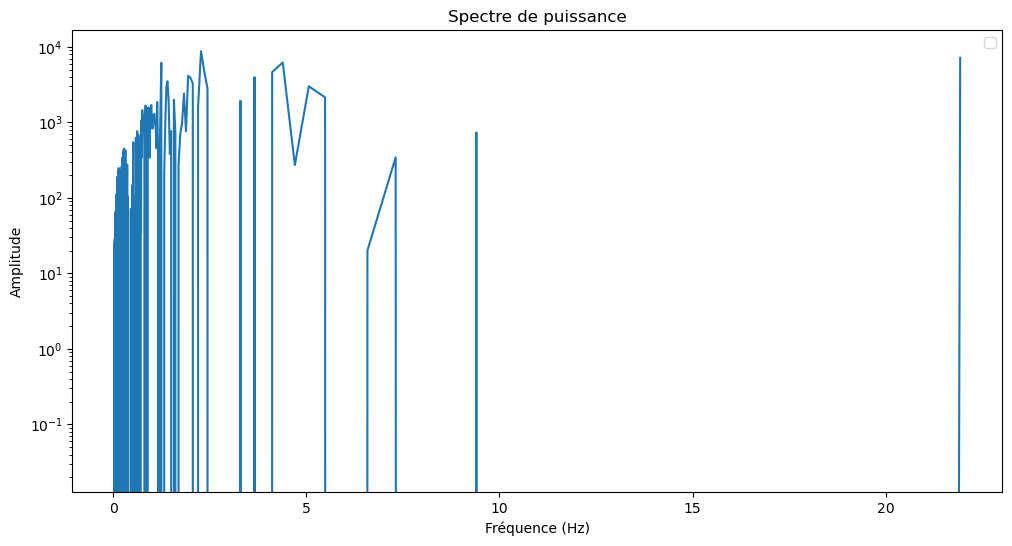

In [101]:
# Paramètres
T = 5*60  # Un point toutes les 5 min d'où 5*60
fs = 1 / T  
N = len(data_ajust) # Nombre de points

# Transformée de Fourier du signal
signal_fft = np.fft.rfft(data_ajust)[3:] # rfft car signal à valeurs réelles
frequences = np.fft.rfftfreq(N, T) # retourne sous forme de complexes
amplitudes = np.real(signal_fft) # on prend la partie réelle


# Affichage
plt.figure(figsize=(12, 6))
plt.semilogy(freq_to_day(frequencies[:len(frequencies)//2]), amplitudes[:len(amplitudes)//2])


# utile pour la suite

plt.legend()

plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

In [103]:
# Détection des pics dans le spectre d'amplitude
peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 0.1)  # Seulement les pics significatifs

# Première fréquence dominante
frequence_principale = frequences[peaks[0]] 
periode_principale = 1 / frequence_principale 
print(f"Fréquence dominante : {frequence_principale*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale / (3600*24):.2f} jours")

Fréquence dominante : 175.90150 1e-8 Hz, soit une période d'environ 6.58 jours


Le résultat attendu n'est pas bon, cela ne correspond à aucune saisonnalité explicable

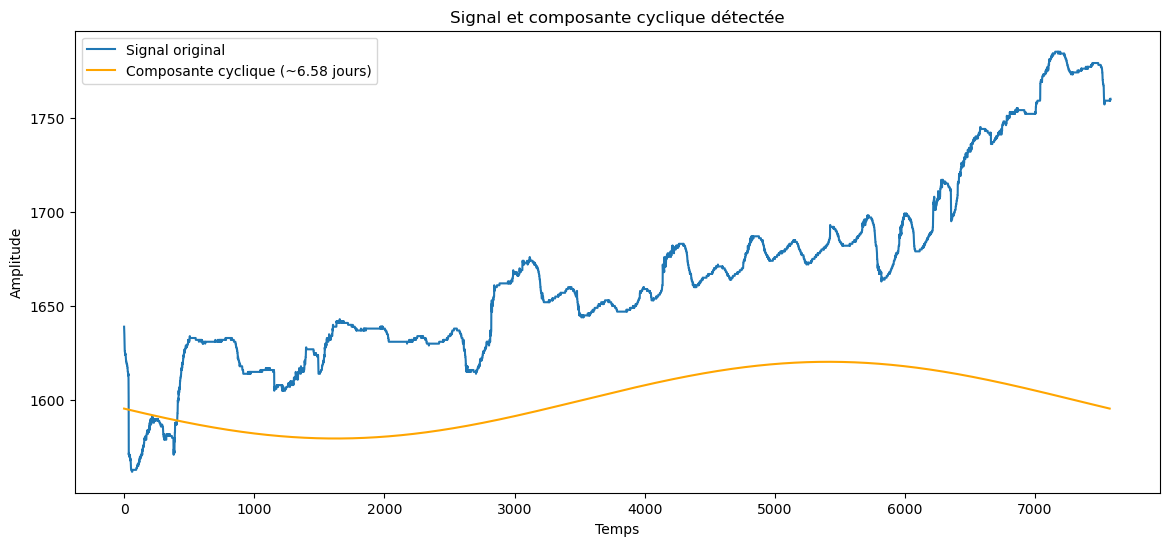

In [115]:
# Filtrage autour de la fréquence dominante
largeur_bande = frequence_principale / 10  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequence_principale) < largeur_bande)[3:]

# Appliquer le filtre pour isoler la composante cyclique
signal_cyclique_fft = signal_fft * filtre_cyclique
signal_cyclique = np.fft.irfft(signal_cyclique_fft)


# Affichage du signal original et de sa composante cyclique
plt.figure(figsize=(14, 6))
plt.plot(data_ajust, label="Signal original")
plt.plot(signal_cyclique.real+1600, label=f"Composante cyclique (~{periode_principale / (3600*24):.2f} jours)", color="orange")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

### Reconstruire le signal avec les fréquences principales

In [119]:
signal_rec = np.zeros(len(data_ajust))
peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 8) 
for p in peaks :
    largeur_bande = frequences[p] / 20  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
    filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequences[p]) < largeur_bande)[3:]

    # Appliquer le filtre pour isoler la composante cyclique
    signal_cyclique_fft = signal_fft * filtre_cyclique
    signal_cyclique = np.fft.irfft(signal_cyclique_fft)
    signal_rec += signal_cyclique

plt.figure(figsize=(14, 6))
plt.plot(data_ajust, label="Signal original")
plt.plot(signal_rec, label="Signal reconstitué ")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (7580,) (7574,) (7580,) 

## Densité spectrale Welch

In [ ]:
# pip install --upgrade scipy

In [121]:
from scipy.signal import welch

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Implémentation de la méthode de Welch
def welch_manual(data, fs, nperseg, noverlap=None):
    # Taille du signal
    n = len(data)
    
    # Calcul de l'overlap
    if noverlap is None:
        noverlap = nperseg // 2
    
    # Nombre de segments
    nsegments = (n - nperseg) // (nperseg - noverlap) + 1
    
    # Fréquences de la FFT
    freqs = np.fft.fftfreq(nperseg, d=1/fs)
    freqs = freqs[:nperseg//2]  # On ne garde que les fréquences positives
    
    # Densité spectrale de puissance
    psd = np.zeros(len(freqs))
    
    for i in range(nsegments):
        # Indices de début et de fin de chaque segment
        start = i * (nperseg - noverlap)
        end = start + nperseg
        
        # Segment du signal
        segment = data[start:end]
        
        # FFT du segment
        fft_segment = np.fft.fft(segment)
        
        # Calcul de la puissance (module au carré de la FFT)
        psd_segment = np.abs(fft_segment[:nperseg//2])**2
        
        # Moyenne des PSDs sur les segments
        psd += psd_segment
    
    psd /= nsegments  # Moyenne sur les segments
    
    return freqs, psd

/var/folders/gn/sy_p6gyd0s15vprgs70pb0dr0000gn/T/ipykernel_34108/303370147.py:40: RuntimeWarning: invalid value encountered in divide
  psd /= nsegments  # Moyenne sur les segments
/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 8192 is greater than input length  = 7580, using nperseg = 7580
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


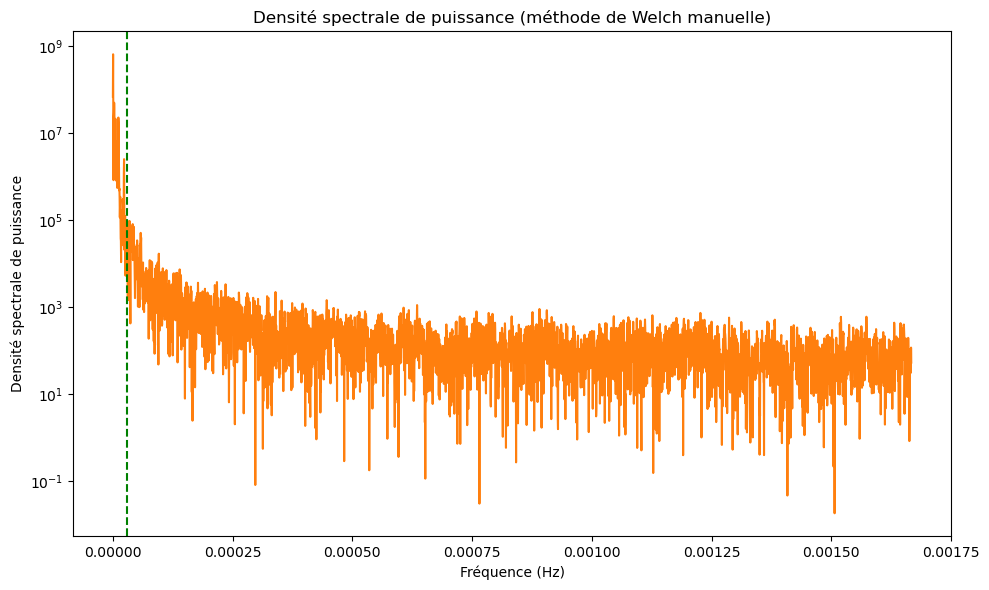

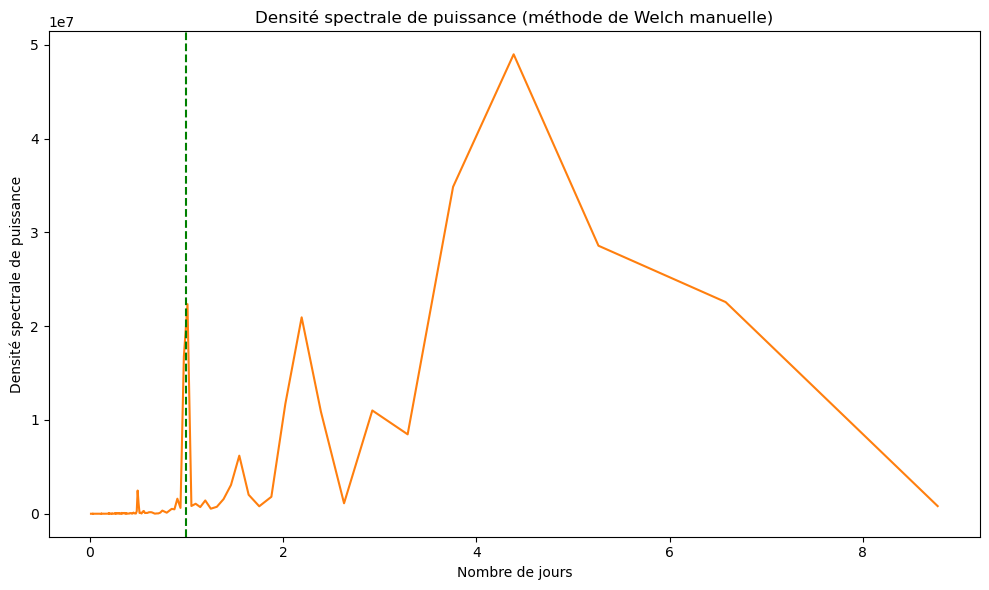

In [133]:
 #Paramètres de la méthode de Welch
nperseg = 8192 # 288
noverlap = int(nperseg/5)
fs = 1 / (60*5)

# Estimation de la PSD avec notre implémentation manuelle de Welch
frequencies_manual, psd_manual = welch_manual(data_ajust, fs, nperseg, noverlap)
frequencies_auto, psd_auto = welch(data_ajust, fs=fs, nperseg=nperseg , noverlap=noverlap, window="hann", scaling = "density")

# Tracé du résultat
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_manual, psd_manual)
plt.semilogy(frequencies_auto, np.abs(psd_auto))
plt.axvline(x=1/(60*24*24), color='green', linestyle='--',label='Cycle diurne')
plt.title('Densité spectrale de puissance (méthode de Welch manuelle)')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(((1/frequencies_manual[3:len(frequencies_manual)//2])/(60*60*24)), psd_manual[3:len(psd_manual)//2])
plt.plot(((1/frequencies_auto[3:len(frequencies_auto)//2])/(60*60*24)), np.abs(psd_auto[3:len(psd_auto)//2]))
plt.axvline(x=1, color='green', linestyle='--',label='Cycle diurne')
plt.title('Densité spectrale de puissance (méthode de Welch manuelle)')
plt.xlabel('Nombre de jours')
plt.ylabel('Densité spectrale de puissance')
plt.tight_layout()
plt.show()


In [135]:
top_3_indices = np.argsort(np.abs(psd_auto))[-20:][::-1]

print(top_3_indices)

# Afficher les indices et les fréquences correspondantes
results = []
for i, index in enumerate(top_3_indices):
    max_psd_frequency_m = frequencies_auto[index]
    result = (1 / max_psd_frequency_m) / (60 * 60 * 24)  # Application de la formule
    results.append(result)
    print(f"Valeur #{i+1} : fréquence = {max_psd_frequency_m}, résultat = {result} jours")
##

max_psd_index_a = np.argmax(np.abs(psd_auto))
print(max_psd_index_a)
max_psd_frequency_a = frequencies_auto[max_psd_index_a]
print(max_psd_frequency_a)

max_psd_index_m = np.argmax(np.abs(psd_manual))
print(max_psd_index_m)
max_psd_frequency_m = frequencies_manual[max_psd_index_m+1]
print(max_psd_frequency_m)


# Afficher la fréquence avec la plus grande PSD
print(f"Fréquence avec la plus grande PSD en manuel : {(1/max_psd_frequency_m)/(60*60*24)} j")
print(f"Fréquence avec la plus grande PSD en auto : {(1/max_psd_frequency_a)/(60*60*24)} j")

[ 1  0  6  7  5  4 26 12 27  2 13  9 11  8 17 18 53 16 14 29]
Valeur #1 : fréquence = 4.3975373790677223e-07, résultat = 26.319444444444443 jours
Valeur #2 : fréquence = 0.0, résultat = inf jours
Valeur #3 : fréquence = 2.6385224274406333e-06, résultat = 4.386574074074074 jours
Valeur #4 : fréquence = 3.0782761653474056e-06, résultat = 3.759920634920635 jours
Valeur #5 : fréquence = 2.198768689533861e-06, résultat = 5.263888888888889 jours
Valeur #6 : fréquence = 1.759014951627089e-06, résultat = 6.579861111111111 jours
Valeur #7 : fréquence = 1.1433597185576078e-05, résultat = 1.0122863247863247 jours
Valeur #8 : fréquence = 5.2770448548812665e-06, résultat = 2.193287037037037 jours
Valeur #9 : fréquence = 1.187335092348285e-05, résultat = 0.9747942386831275 jours
Valeur #10 : fréquence = 8.795074758135445e-07, résultat = 13.159722222222221 jours
Valeur #11 : fréquence = 5.716798592788039e-06, résultat = 2.0245726495726495 jours
Valeur #12 : fréquence = 3.95778364116095e-06, résultat 

/var/folders/gn/sy_p6gyd0s15vprgs70pb0dr0000gn/T/ipykernel_34108/2915299488.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  result = (1 / max_psd_frequency_m) / (60 * 60 * 24)  # Application de la formule


Explication :

Il doit exister une composante cyclique au delà de notre domaine d'étude ( 1 an ? ). C'est pour cela qu'à chaque fois que l'on augmente nperseg, on affine notre précision spectrale, permettant d'attraper des fréquences plus petite ( donc des périodes plus longues). En fait la fréquence principales correspond à ce que Welch a pu comprendre de ce fameux cycle annuel ( d'où la plus grande fréquence possible à chaque fois). Ensuite si l'on affiche les autres fréquences importantes on voit qu'il y a les fréquences proches de la fréquences principales. Celles-ci ne sont pas représentatives mais on été artificiellement grossi par le spectral leakage. Cependant la prochaine fréquence intéressante qui apparait "d'elle même" est celle correspondant à 1j ( modulo les virgules du à la précision spectrale ). Cela confirme bien qu'une des composantes principales est le cycle diurne

Que l'on fasse Welch avec la fonction déjà implémentée ou Welch à la main, on trouve la même fréquence principale. Ce qui démontre la cohérence "sémantique". Toutefois le résultats obtenu n'est toujours pas celui attendu

1
6.510416666666667e-06
La plus basse fréquence principale est : 6.510416666666667e-06 Hz
Ca correspond à  : 1.7777777777777777 jours


/var/folders/gn/sy_p6gyd0s15vprgs70pb0dr0000gn/T/ipykernel_34108/3110729536.py:44: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/frequencies/(60*60*24), np.abs(power_spectral_density), label="Densité spectrale")


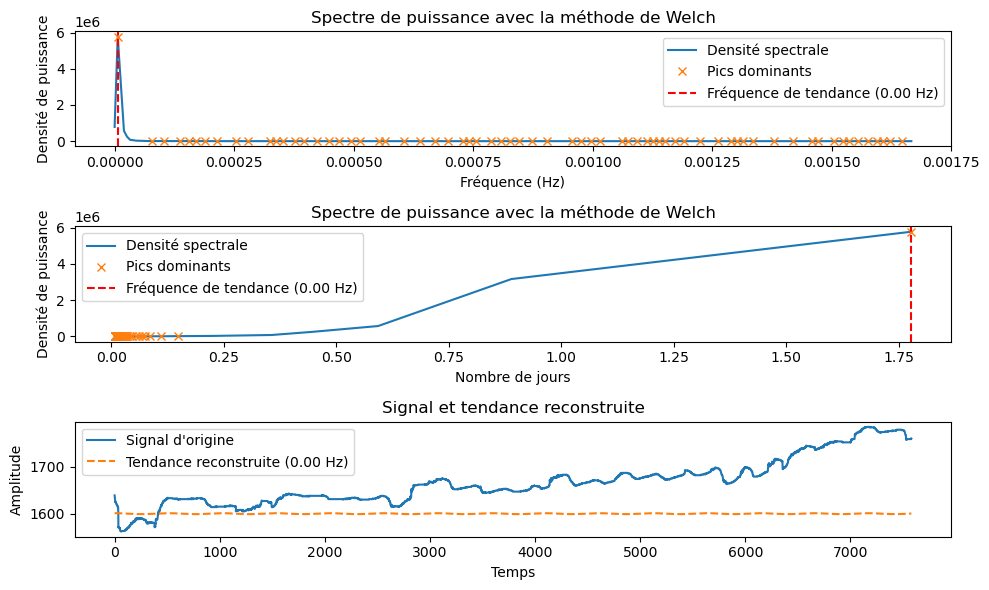

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from scipy.fft import ifft

signal = data_ajust  
T = 60*5 
fs = 1 / T  

# Décomposition spectrale de Welch
frequencies, power_spectral_density = welch(signal, fs=fs, nperseg=512, noverlap = 512/2)

# Identification des fréquences dominantes
peaks, _ = find_peaks(np.abs(power_spectral_density))
dominant_frequencies = frequencies[peaks]
dominant_powers = power_spectral_density[peaks]

# Recherche de la plus basse fréquence dominante
max_psd_index = np.argmax(np.abs(power_spectral_density))
print(max_psd_index)
max_psd_frequency = frequencies[max_psd_index]
print(max_psd_frequency)

print(f"La plus basse fréquence principale est : {max_psd_frequency} Hz")
print(f"Ca correspond à  : {(1/max_psd_frequency) /(60*60*24)} jours")

# Reconstruction de la tendance par filtrage
# On construit un signal harmonique avec la fréquence de tendance
t = np.arange(len(signal)) / fs
trend = np.cos(2 * np.pi * max_psd_frequency * t)

# Visualisation
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(frequencies, np.abs(power_spectral_density), label="Densité spectrale")
plt.plot(dominant_frequencies, np.abs(dominant_powers), "x", label="Pics dominants")
plt.axvline(max_psd_frequency, color='r', linestyle='--', label=f"Fréquence de tendance ({max_psd_frequency:.2f} Hz)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité de puissance")
plt.legend()
plt.title("Spectre de puissance avec la méthode de Welch")

plt.subplot(3, 1, 2)
plt.plot(1/frequencies/(60*60*24), np.abs(power_spectral_density), label="Densité spectrale")
plt.plot(1/dominant_frequencies/(60*60*24), np.abs(dominant_powers), "x", label="Pics dominants")
plt.axvline(1/max_psd_frequency/(60*60*24), color='r', linestyle='--', label=f"Fréquence de tendance ({max_psd_frequency:.2f} Hz)")
plt.xlabel("Nombre de jours")
plt.ylabel("Densité de puissance")
plt.legend()
plt.title("Spectre de puissance avec la méthode de Welch")

plt.subplot(3, 1, 3)
plt.plot(signal, label="Signal d'origine")
plt.plot(trend+1600, label=f"Tendance reconstruite ({max_psd_frequency:.2f} Hz)", linestyle='--')
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Signal et tendance reconstruite")

plt.tight_layout()
plt.show()


# Modélisation des séries temporelles

### Modélisation avec la librairie STL

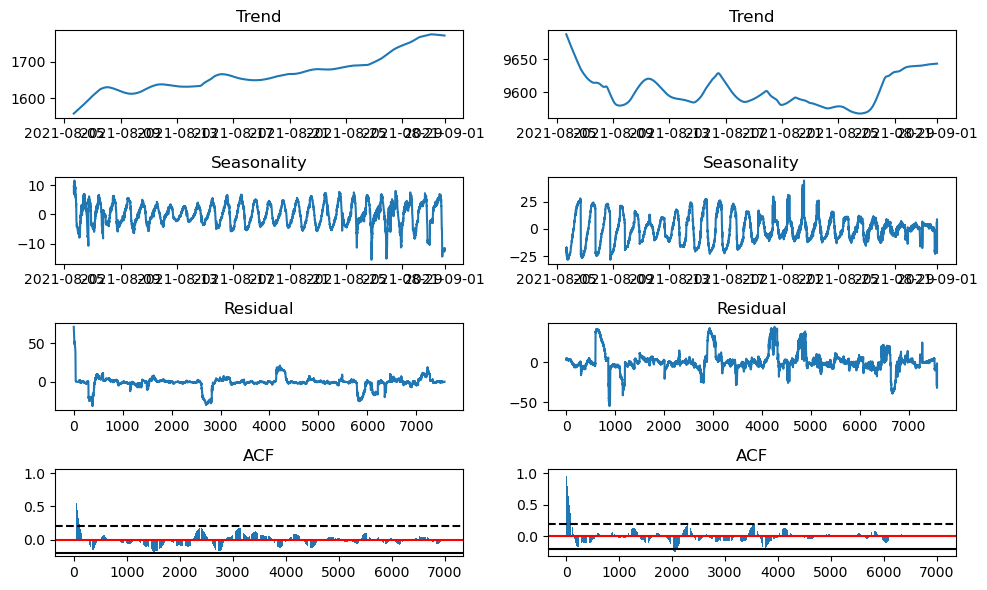

In [30]:
stl1 = STL(time_serie_crop, period=5*60, robust = True)
result_stl1 = stl1.fit()

stl2 = STL(time_serie_crop2, period=5*60, robust = True)
result_stl2 = stl2.fit()

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_stl1.resid, nlags = max_lag)
acf_values_2 = sm.tsa.acf(result_stl2.resid, nlags = max_lag)

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

ax[0,0].plot(datetime_data,result_stl1.trend)
ax[0,0].set_title('Trend')
ax[1,0].plot(datetime_data,result_stl1.seasonal)
ax[1,0].set_title('Seasonality')
ax[2,0].plot(result_stl1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_stl2.trend)
ax[0,1].set_title('Trend')
ax[1,1].plot(datetime_data,result_stl2.seasonal)
ax[1,1].set_title('Seasonality')
ax[2,1].plot(result_stl2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')
ax[3,0].set_title('ACF')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')
ax[3,1].set_title('ACF')

plt.tight_layout()
plt.show()

### Modélisation avec la librairie MSTL

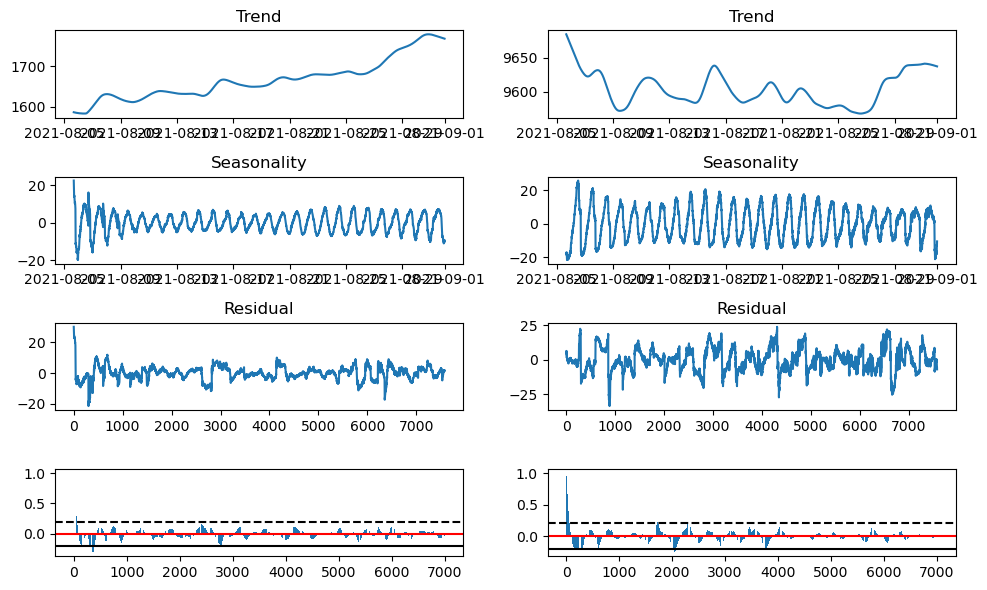

In [37]:
from statsmodels.tsa.seasonal import MSTL

mstl1 = MSTL(time_serie_crop, periods=5*60)
result_mstl1 = mstl1.fit()

mstl2 = MSTL(time_serie_crop2, periods=5*60)
result_mstl2 = mstl2.fit()

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_mstl1.resid, nlags = max_lag)
acf_values_2 = sm.tsa.acf(result_mstl2.resid, nlags = max_lag)

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

ax[0,0].plot(datetime_data,result_mstl1.trend)
ax[0,0].set_title('Trend')
ax[1,0].plot(datetime_data,result_mstl1.seasonal)
ax[1,0].set_title('Seasonality')
ax[2,0].plot(result_mstl1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_mstl2.trend)
ax[0,1].set_title('Trend')
ax[1,1].plot(datetime_data,result_mstl2.seasonal)
ax[1,1].set_title('Seasonality')
ax[2,1].plot(result_mstl2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')

plt.tight_layout()
plt.show()

### Modélisation avec seasonal_decompose

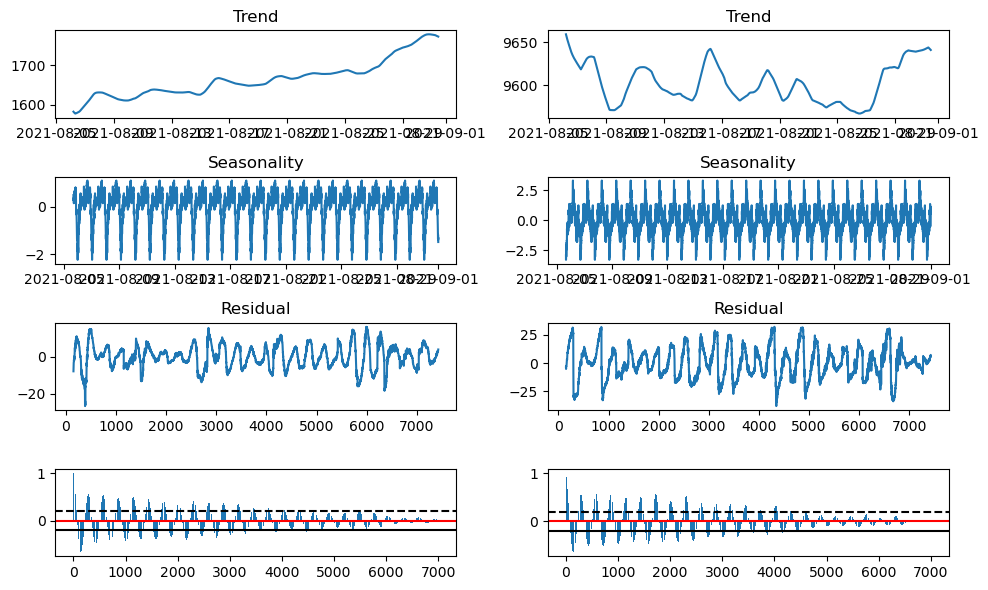

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_sd1 = seasonal_decompose(time_serie_crop, model='additive', period=60*5)
result_sd2 = seasonal_decompose(time_serie_crop2, model='additive', period=60*5)

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_sd1.resid, nlags = max_lag, missing="drop")
acf_values_2 = sm.tsa.acf(result_sd2.resid, nlags = max_lag, missing="drop")

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

ax[0,0].plot(datetime_data,result_sd1.trend)
ax[0,0].set_title('Trend')
ax[1,0].plot(datetime_data,result_sd1.seasonal)
ax[1,0].set_title('Seasonality')
ax[2,0].plot(result_sd1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_sd2.trend)
ax[0,1].set_title('Trend')
ax[1,1].plot(datetime_data,result_sd2.seasonal)
ax[1,1].set_title('Seasonality')
ax[2,1].plot(result_sd2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')

plt.tight_layout()
plt.show()

# Analyse de la saisonnalité (périodes et déphasage)

## STL

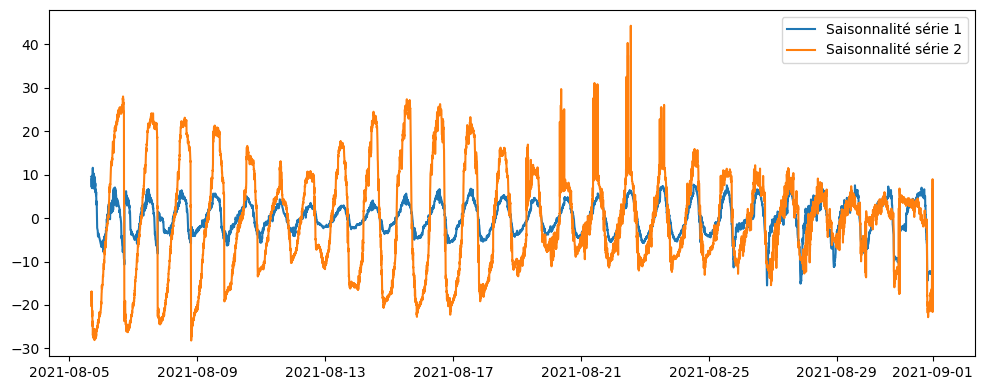

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(datetime_data,result_stl1.seasonal, label = "Saisonnalité série 1")
plt.plot(datetime_data,result_stl2.seasonal, label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
seasonal1 = result_stl1.seasonal
seasonal2 = result_stl2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 879.50748 1e-8 Hz, soit une période d'environ 1.32 jours
Série 2 --> Fréquence dominante : 1187.33509 1e-8 Hz, soit une période d'environ 0.97 jours


Déphasage : -20.0 min


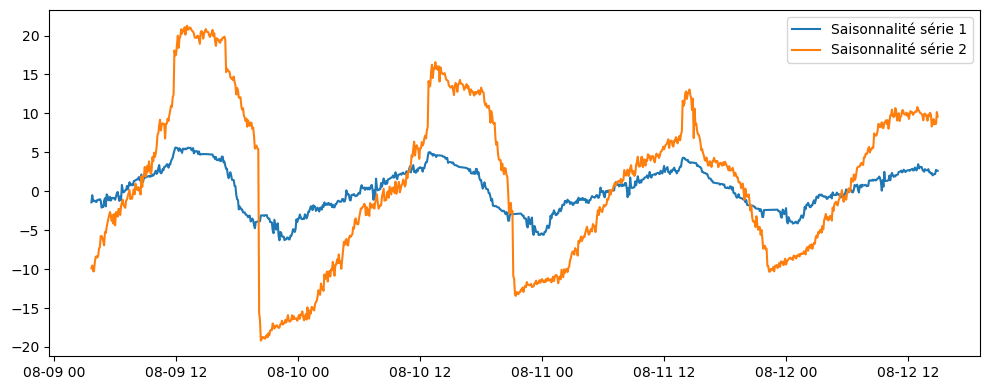

In [77]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 4))
plt.plot(datetime_data[1000:2000],result_stl1.seasonal[1000:2000], label = "Saisonnalité série 1")
plt.plot(datetime_data[1000:2000],result_stl2.seasonal[1000:2000], label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()

## MSTL

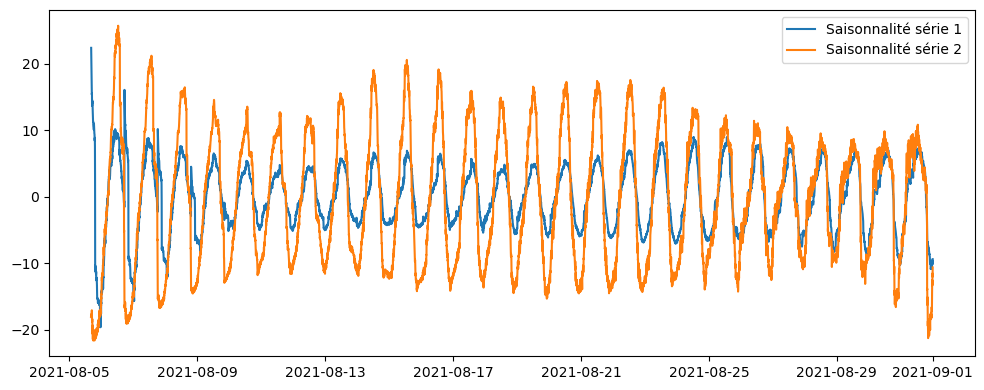

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(datetime_data,result_mstl1.seasonal, label = "Saisonnalité série 1")
plt.plot(datetime_data,result_mstl2.seasonal, label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
seasonal1 = result_mstl1.seasonal
seasonal2 = result_mstl2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 1231.31047 1e-8 Hz, soit une période d'environ 0.94 jours
Série 2 --> Fréquence dominante : 1187.33509 1e-8 Hz, soit une période d'environ 0.97 jours


Déphasage : -25.0 min


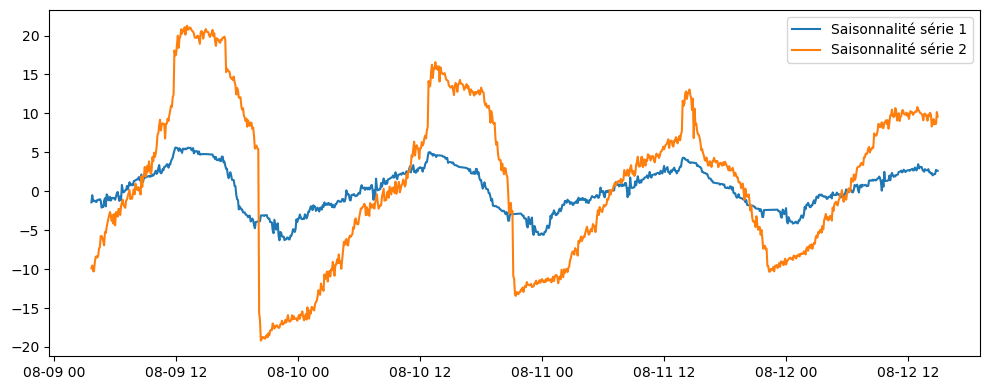

In [81]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 4))
plt.plot(datetime_data[1000:2000],result_stl1.seasonal[1000:2000], label = "Saisonnalité série 1")
plt.plot(datetime_data[1000:2000],result_stl2.seasonal[1000:2000], label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Decompose (SD)

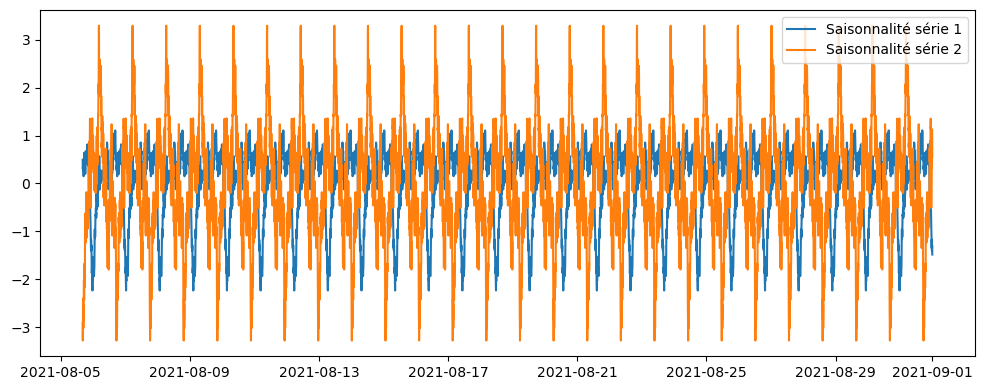

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(datetime_data, result_sd1.seasonal, label = "Saisonnalité série 1")
plt.plot(datetime_data,result_sd2.seasonal, label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
seasonal1 = result_sd1.seasonal
seasonal2 = result_sd2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 1143.35972 1e-8 Hz, soit une période d'environ 1.01 jours
Série 2 --> Fréquence dominante : 1143.35972 1e-8 Hz, soit une période d'environ 1.01 jours


Déphasage : 0.0 min


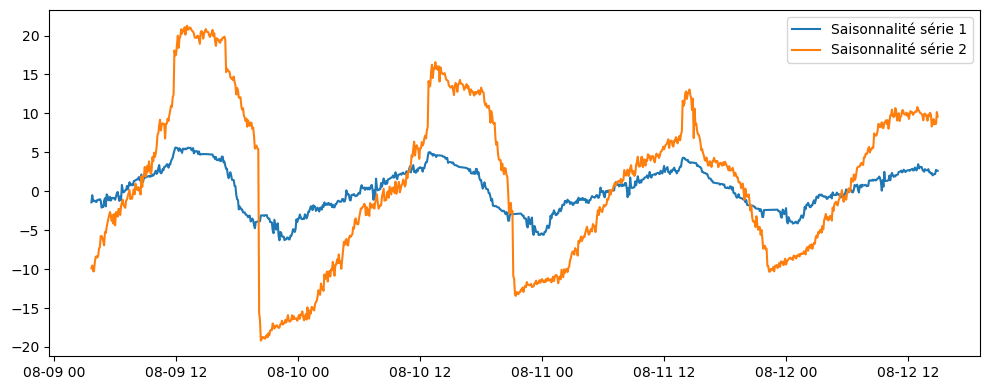

In [85]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 4))
plt.plot(datetime_data[1000:2000],result_stl1.seasonal[1000:2000], label = "Saisonnalité série 1")
plt.plot(datetime_data[1000:2000],result_stl2.seasonal[1000:2000], label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()